In [1]:
#importing libraries
import torch
import torchvision.transforms as transforms
import os
from torch.autograd import Variable
from model import Generator , Discriminator
import Utility
import Dataset_util
from PIL import Image


In [2]:
import os
os.listdir('./facades')

['facades_models', 'facades_results', 'test', 'train', 'val']

In [6]:
#defining the directories
data_dir = './facades/'
save_dir = './facades/facades_results/'
model_dir = './facades/facades_models/'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [3]:
#Defining the parameters

direction = 'BtoA'
batch_size = 1
ngf , ndf = 64,64
input_size = 256
resize_scale = 286
crop_size = 256
flip = True
num_epochs = 10
lrG , lrD = 0.0002 , 0.0002
Lambda = 100 #lambda for L1 loss

beta1 , beta2 = 0.5,0.999 #beta values for adam optimizer


In [4]:
#Defining the transforms
transform = transforms.Compose([transforms.Resize(input_size) , transforms.ToTensor() ,
                               transforms.Normalize(mean = (0.5,0.5,0.5) , std = (0.5,0.5,0.5))])



In [6]:
train_data = Dataset_util.CreateDataset(data_dir , subfolder = 'train' ,direction = direction , transform = transform,
                                  resize_scale = resize_scale , crop_size = crop_size , flip= flip)

In [7]:
#lets create training loader
train_loader = torch.utils.data.DataLoader(dataset = train_data , batch_size = batch_size , shuffle = True)


In [8]:
data = iter(train_loader)
img , p = data.next()
print(img.shape , p.shape)

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


In [7]:
#lets create test data
test_data = Dataset_util.CreateDataset(data_dir , subfolder ='test' , direction = direction , transform = transform)


In [8]:
#Creating test_loader
test_loader = torch.utils.data.DataLoader(dataset = test_data , shuffle = False , batch_size = batch_size)


In [11]:
test_input, test_target = test_loader.__iter__().__next__()

In [9]:
#Models

Gen = Generator(3 , ngf , 3)
print(Gen)

Generator(
  (conv1): BuildConv(
    (Conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (leaky_relu): LeakyReLU(negative_slope=0.2, inplace)
    (BatchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): BuildConv(
    (Conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (leaky_relu): LeakyReLU(negative_slope=0.2, inplace)
    (BatchNorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BuildConv(
    (Conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (leaky_relu): LeakyReLU(negative_slope=0.2, inplace)
    (BatchNorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): BuildConv(
    (Conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (leaky_relu): LeakyReLU(negative_slope=0.2, inplace)
    (BatchNorm): BatchNorm2d(512, eps=1e-05, momentu

In [10]:
#Discriminator
Discr = Discriminator(6 , ndf , 1)
print(Discr)

Discriminator(
  (conv1): BuildConv(
    (Conv): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (leaky_relu): LeakyReLU(negative_slope=0.2, inplace)
    (BatchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): BuildConv(
    (Conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (leaky_relu): LeakyReLU(negative_slope=0.2, inplace)
    (BatchNorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BuildConv(
    (Conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (leaky_relu): LeakyReLU(negative_slope=0.2, inplace)
    (BatchNorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): BuildConv(
    (Conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (leaky_relu): LeakyReLU(negative_slope=0.2, inplace)
    (BatchNorm): BatchNorm2d(512, eps=1e-05, mom

In [11]:
if torch.cuda.is_available():
    Gen.cuda()
    Discr.cuda()

In [15]:
Gen.normal_weight_init(mean= 0.0 , std = 0.02)
Discr.normal_weight_init(mean = 0.0 , std  = 0.02)


In [16]:
#Loss functions
bce_loss = torch.nn.BCELoss()
l1_loss = torch.nn.L1Loss()




In [17]:
#Defining the optimizers
G_optim = torch.optim.Adam(Gen.parameters() , lr = lrG , betas = (beta1 , beta2))
D_optim = torch.optim.Adam(Discr.parameters() , lr = lrD , betas = (beta1 , beta2))


In [19]:
########Training############
import time
print_every = 50
start = time.time()
G_avg_loss , D_avg_loss = [] , []
for epoch in range(num_epochs):
    
    g_loss , d_loss = [] , []
    for i , (inp , target) in enumerate(train_loader):
        
        x , y = Variable(inp.cuda()) , Variable(target.cuda())
        
        #Training the discriminator with real_data
        D_real = Discr(x , y).squeeze()
        real_target = Variable(torch.ones(D_real.size()).cuda())
        D_real_loss = bce_loss(D_real , real_target)
        
        #Training the discriminator with fake images
        gen_img = Gen(x)
        D_fake = Discr(x , gen_img).squeeze()
        fake_target = Variable(torch.ones(D_fake.size()).cuda())
        
        D_fake_loss = bce_loss(D_fake , fake_target)
        
        #Back Propogation
        D_loss = (D_real_loss + D_fake_loss) * 0.5
        D_optim.zero_grad()
        D_loss.backward()
        D_optim.step()
        
        #Training the Generator
        gen_img = Gen(x)
        D_fake_decision = Discr(x , gen_img).squeeze()
        G_fake_loss = bce_loss(D_fake_decision , real_target)
        
        #L1 loss
        
        G_l1 = Lambda*l1_loss(gen_img, y)
        
        #total generator loss
        
        G_loss = G_l1 + G_fake_loss
        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()
        
        
        g_loss.append(G_loss.item())
        d_loss.append(D_loss.item())
        if(i % print_every) == 0 :
            print("Epoch[{}/{}]|| D_loss : {:.4f} || G_loss : {:.4f}".format(epoch + 1 , num_epochs
                                                                 , D_loss.item() , G_loss.item()))
        
    #avg_loss values
    G_avg_loss.append(torch.mean(torch.FloatTensor(g_loss)))
    D_avg_loss.append(torch.mean(torch.FloatTensor(d_loss)))
    
    #Showing result for test image
    gen_image = Gen(Variable(test_input.cuda()))
    gen_image = gen_image.cpu().data
    Utility.plot_test_result(test_input , test_target , gen_image , epoch ,save = True ,save_dir = save_dir)
print(time.time() - start)
    
#Plot average losses
#Utility.plot_loss(G_avg_loss , D_avg_loss , num_epochs , save = True , save_dir = save_dir)

#make gif
#Utility.generate_gif('maps' , num_epochs , save_dir = save_dir)
    


Epoch[1/10]|| D_loss : 0.6827 || G_loss : 33.3376
Epoch[1/10]|| D_loss : 0.0102 || G_loss : 27.5106
Epoch[1/10]|| D_loss : 0.0028 || G_loss : 27.6809
Epoch[1/10]|| D_loss : 0.0014 || G_loss : 41.5434
Epoch[1/10]|| D_loss : 0.0010 || G_loss : 43.1243
Epoch[1/10]|| D_loss : 0.0007 || G_loss : 48.0038
Epoch[1/10]|| D_loss : 0.0005 || G_loss : 39.2584
Epoch[1/10]|| D_loss : 0.0005 || G_loss : 43.7910


c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


Epoch[2/10]|| D_loss : 0.0004 || G_loss : 22.8930
Epoch[2/10]|| D_loss : 0.0003 || G_loss : 30.5993
Epoch[2/10]|| D_loss : 0.0003 || G_loss : 28.9125
Epoch[2/10]|| D_loss : 0.0002 || G_loss : 35.3680
Epoch[2/10]|| D_loss : 0.0002 || G_loss : 44.3434
Epoch[2/10]|| D_loss : 0.0002 || G_loss : 36.7032
Epoch[2/10]|| D_loss : 0.0002 || G_loss : 31.7502
Epoch[2/10]|| D_loss : 0.0001 || G_loss : 31.5544
Epoch[3/10]|| D_loss : 0.0001 || G_loss : 28.4828
Epoch[3/10]|| D_loss : 0.0001 || G_loss : 20.0865
Epoch[3/10]|| D_loss : 0.0001 || G_loss : 45.9445
Epoch[3/10]|| D_loss : 0.0001 || G_loss : 23.2205
Epoch[3/10]|| D_loss : 0.0001 || G_loss : 53.7366
Epoch[3/10]|| D_loss : 0.0001 || G_loss : 40.0581
Epoch[3/10]|| D_loss : 0.0001 || G_loss : 26.7058
Epoch[3/10]|| D_loss : 0.0001 || G_loss : 33.1140
Epoch[4/10]|| D_loss : 0.0001 || G_loss : 37.2553
Epoch[4/10]|| D_loss : 0.0001 || G_loss : 26.0676
Epoch[4/10]|| D_loss : 0.0001 || G_loss : 24.2912
Epoch[4/10]|| D_loss : 0.0001 || G_loss : 34.6970


[]

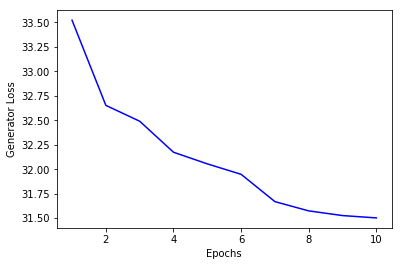

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(1 , num_epochs + 1),G_avg_loss , color = 'blue')

plt.xlabel('Epochs')
plt.ylabel("Generator Loss")
plt.plot()


[]

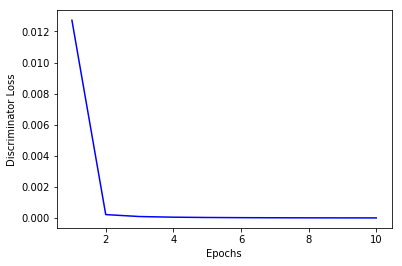

In [23]:
plt.plot(range(1 , num_epochs + 1),D_avg_loss , color = 'blue')

plt.xlabel('Epochs')
plt.ylabel("Discriminator Loss")
plt.plot()

In [25]:
# Save trained parameters of model
torch.save(Gen.state_dict(), model_dir + 'generator_param.pkl')
torch.save(Discr.state_dict(), model_dir + 'discriminator_param.pkl')

In [22]:
save_test_dir = './facades/test_results/'
if not os.path.exists(save_test_dir):
    os.mkdir(save_test_dir)

In [13]:
Gen.load_state_dict(torch.load(model_dir + 'generator_param.pkl'))

In [23]:
#Testing
for i ,(inp , target) in enumerate(test_loader):
    
    x , y = Variable(inp.cuda()) , Variable(target.cuda())
    gen_image = Gen(x)
    gen_image = gen_image.cpu()
    
    Utility.plot_test_result(inp , target, gen_image , i ,training = False , save = True , save_dir = save_test_dir)
    print('%d images are generated.' % (i + 1))

1 images are generated.
2 images are generated.
3 images are generated.
4 images are generated.
5 images are generated.
6 images are generated.
7 images are generated.
8 images are generated.
9 images are generated.
10 images are generated.
11 images are generated.
12 images are generated.
13 images are generated.
14 images are generated.
15 images are generated.
16 images are generated.
17 images are generated.
18 images are generated.
19 images are generated.
20 images are generated.
21 images are generated.
22 images are generated.
23 images are generated.
24 images are generated.
25 images are generated.
26 images are generated.
27 images are generated.
28 images are generated.
29 images are generated.
30 images are generated.
31 images are generated.
32 images are generated.
33 images are generated.
34 images are generated.
35 images are generated.
36 images are generated.
37 images are generated.
38 images are generated.
39 images are generated.
40 images are generated.
41 images

In [34]:
#Function to create GIFs
import imageio
def generate_gif(dataset , num_epochs , save_dir = 'results/'):
    
    gen_image_plot = []
    
    for epoch in range(num_epochs):
        save_fn = save_dir + 'Test_result_{:d}'.format(epoch + 1) +'.png'
        gen_image_plot.append(imageio.imread(save_fn))
        
    imageio.mimsave(save_dir + dataset + '_pix2pix_epochs_{}'.format(num_epochs) + '.gif', gen_image_plot, fps=5)
    

    

In [35]:
#lets create gifs
generate_gif('facades' , 10 , save_test_dir)

_pix2pix_epochs_10
